In [1]:
import numpy as np

import torch
import torch.nn as nn
#import torch.nn.functional as F
import torch.distributions as distrib
#import torch.distributions.transforms as transform
import torch.optim as optim

In [2]:
from normalizing_flows import NormalizingFlow
from normalizing_flows.flows import AffineLUFlow, PReLUFlow

In [3]:
import matplotlib.pyplot as plt
import datetime

from copy import deepcopy

from tqdm import trange
from tensorboardX import SummaryWriter

In [4]:
now_str = lambda : str(datetime.datetime.now()).replace(" ", "__")

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [51]:
def gen_samples(batch_size=512):
    x2_dist = distrib.Normal(loc=0., scale=4.)
    x2_samples = x2_dist.sample((batch_size,))

    x1 = distrib.Normal(loc=.25 * (x2_samples.pow(2)),
                  scale=torch.ones((batch_size,)))
    
    x1_samples = x1.sample()
    return torch.stack([x1_samples, x2_samples]).t()

x_samples = gen_samples(512)

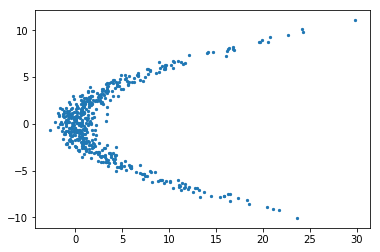

In [52]:
plt.scatter(x_samples[:, 0], x_samples[:, 1], s=5)
plt.show()

In [53]:
base_dist = distrib.Normal(loc=torch.zeros(2), scale=torch.ones(2))

In [54]:
X0 = base_dist.sample((1000,)).numpy()

In [55]:
colors = np.zeros(len(X0))

idx_0 = np.logical_and(X0[:, 0] < 0, X0[:, 1] < 0)
colors[idx_0] = 0
idx_1 = np.logical_and(X0[:, 0] >= 0, X0[:, 1] < 0)
colors[idx_1] = 1
idx_2 = np.logical_and(X0[:, 0] >= 0, X0[:, 1] >= 0)
colors[idx_2] = 2
idx_3 = np.logical_and(X0[:, 0] < 0, X0[:, 1] >= 0)
colors[idx_3] = 3

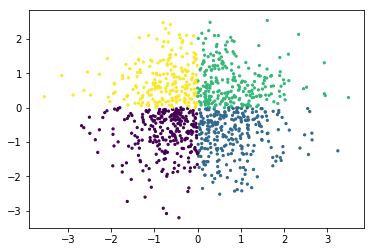

In [56]:
plt.scatter(X0[:, 0], X0[:, 1], s=5, c=colors)

In [57]:
flow = NormalizingFlow(
    dim=2, 
    blocks=([AffineLUFlow, PReLUFlow]*5 + [AffineLUFlow]),
    base_density=base_dist,
    flow_length=1
)

opt = optim.Adam(flow.parameters(), lr=1e-3)

#scheduler = optim.lr_scheduler.ExponentialLR(opt, 0.9999)

In [60]:
writer = SummaryWriter(f"/workspace/sandbox/tensorboard_logs/{now_str()}")

best_loss = torch.Tensor([float("+inf")])

for it in trange(int(1e5)):

    opt.zero_grad()
    loss = -flow.final_density.log_prob(x_samples).mean()
    if loss <= best_loss:
        best_loss = loss
        best_flow = deepcopy(flow)
    loss.backward()
    if it % 50 == 0:
        writer.add_scalar("loss", loss, it)

    opt.step()
    #scheduler.step()

100%|██████████| 100000/100000 [25:33<00:00, 65.21it/s] 


In [61]:
flow = best_flow

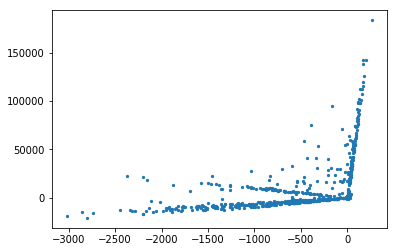

In [62]:
xhat_samples = flow.final_density.sample((1000, ))
plt.scatter(xhat_samples[:, 0], xhat_samples[:, 1], s=5)
#plt.xlim(0, 60)
#plt.ylim(-15, 15)
plt.show()

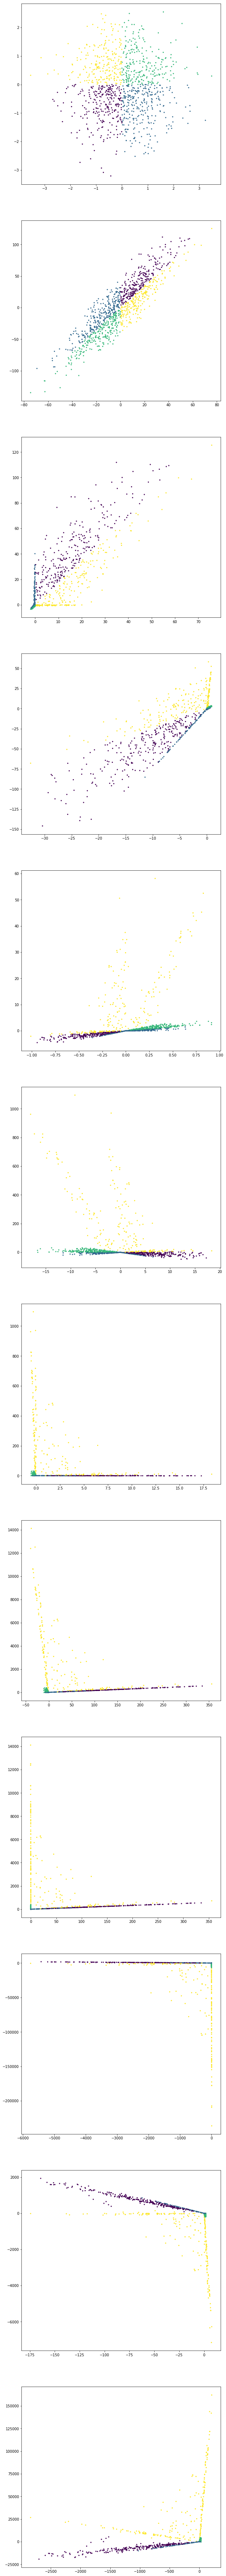

In [64]:
n_flows = len(flow.bijectors)

f, axs = plt.subplots(
    n_flows + 1,
    1,
    figsize=(10, n_flows*12),
    #sharex=True,
    #sharey=True
)

axs[0].scatter(X0[:, 0], X0[:, 1], s=5, c=colors)

cur_x = X0

for ax, bij in zip(axs[1:], flow.bijectors[:n_flows+1]):
    cur_x = bij(torch.Tensor(cur_x)).detach().numpy()
    ax.scatter(cur_x[:, 0], cur_x[:, 1], s=5, c=colors)
    
plt.show()

In [65]:
x = np.linspace(-4, 4, 1000)
z = np.array(np.meshgrid(x, x)).transpose(1, 2, 0)
z = np.reshape(z, [z.shape[0] * z.shape[1], -1])

In [66]:
def get_density(cur_z, prev_density, flow):
    density = prev_density.squeeze() / np.exp(flow.log_abs_det_jacobian(torch.Tensor(cur_z), None).detach().squeeze())
    return torch.Tensor(density)

In [67]:
def get_meshes(cur_z, density, grid_side=1000, dim=2):
    mesh = cur_z.reshape([grid_side, grid_side, dim]).transpose(2, 0, 1)
    xx = mesh[0]
    yy = mesh[1]
    zz = density.numpy().reshape([grid_side, grid_side])
    
    return xx, yy, zz

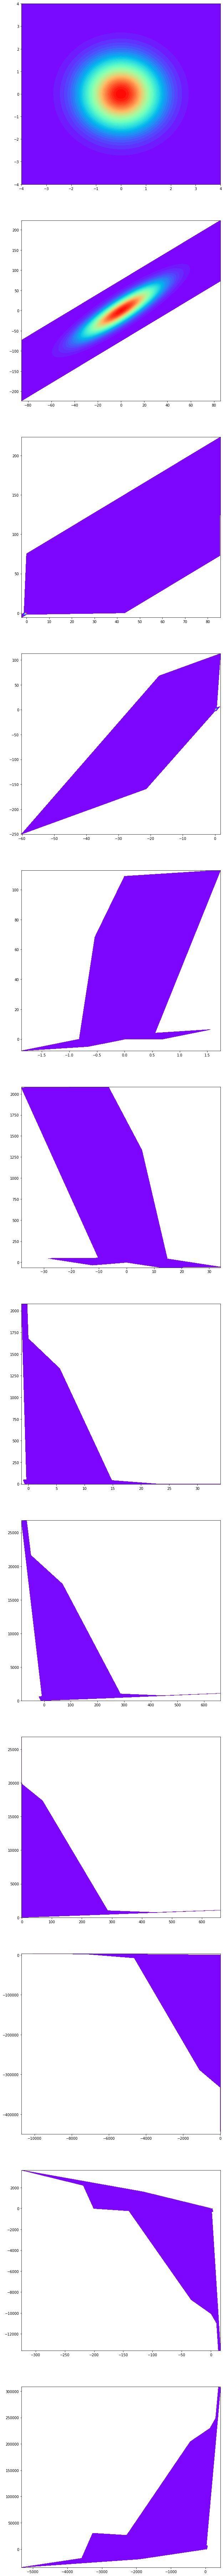

In [68]:
f, axs = plt.subplots(
    n_flows + 1,
    1,
    figsize=(10, n_flows*12),
    #sharex=True,
    #sharey=True
)

cur_z = z
prev_density = (flow.base_density
                    .log_prob(torch.Tensor(cur_z))
                    .sum(dim=1)
                    .exp().detach())

xx, yy, zz = get_meshes(cur_z, prev_density)

axs[0].contourf(xx, yy, zz, 50, cmap='rainbow')

for ax, bij in zip(axs[1:], flow.bijectors[:n_flows+1]):
    cur_z = bij(torch.Tensor(cur_z)).detach().numpy()
    
    prev_density = get_density(cur_z, prev_density, bij)
    xx, yy, zz = get_meshes(cur_z, prev_density)
    ax.contourf(xx, yy, zz, 50, cmap='rainbow')
    
plt.show()